# Planetesimal Formation
Pluto Jiang 2024

## Imports

In [1]:
import os
import json
import sys
# Add the path to the DiscEvolution directory
sys.path.append(os.path.abspath(os.path.join('..')) + '/DiscEvolution')

import numpy as np
import matplotlib.pyplot as plt

from constants import *
from grid import Grid
from star import SimpleStar
from eos import IrradiatedEOS, LocallyIsothermalEOS
from dust import *
from viscous_evolution import ViscousEvolution, ViscousEvolutionFV
from disc import AccretionDisc
from dust import SingleFluidDrift

c:\Users\rocks\DiscEvolution-Branch/DiscEvolution\dust.py:1028: SyntaxWarning: invalid escape sequence '\,'
  axes[0].set_xlabel('$R\,[\mathrm{au}]$')
c:\Users\rocks\DiscEvolution-Branch/DiscEvolution\dust.py:1029: SyntaxWarning: invalid escape sequence '\S'
  axes[0].set_ylabel('$\Sigma_{\mathrm{Planetesimal}}$')
c:\Users\rocks\DiscEvolution-Branch/DiscEvolution\dust.py:1034: SyntaxWarning: invalid escape sequence '\,'
  axes[1].set_xlabel('$R\,[\mathrm{au}]$')
c:\Users\rocks\DiscEvolution-Branch/DiscEvolution\dust.py:1035: SyntaxWarning: invalid escape sequence '\S'
  axes[1].set_ylabel('$\Sigma_{\mathrm{Dust}}$')
c:\Users\rocks\DiscEvolution-Branch/DiscEvolution\dust.py:1040: SyntaxWarning: invalid escape sequence '\,'
  axes[2].set_xlabel('$R\,[\mathrm{au}]$')


## Config Parameters

In [2]:
# Grid parameters
# -------------------------
rmin = 0.1 # Minimum radius, AU
rmax = 1000 # Maximum radius, AU
nr = 1000 # Number of radial grid points
spacing = "natural"

# Simulation parameters
# -------------------------
t_initial = 0 # inital time, years
t_final = 1e6 # final time, years
t_interval = "power" # interval to output disk properties, years

# Disc parameters
# -------------------------
alpha = 1e-3 # viscosity parameter
mdot = 1e-8 * Msun / (2 * np.pi) / AU**2 # accretion rate, Msun/yr

# EOS parameters
# -------------------------
eos = "LocallyIsothermalEOS" # Equation of state to use
h0 = 1/30 # disc aspect ratio at 1AU
q = -0.25 # power law index of sound speed


# Dust growth parameters
# -------------------------
d2g = 0.01 # initial dust-to-gas mass ratio
feedback = False # dust feedback
settling = False # dust settling


# Planetesimal Parameters
planetesimal_formation = False
planetesimal_diameter = 100 # km


## Planetesimal Formation Simulation

In [5]:
def run_model():
    """
    
    """
    # Set up model
    # ========================
    # Create the grid
    grid = Grid(rmin, rmax, nr, spacing)
    
    # Create time array
    if t_interval == "power":
        # Determine the number of points needed
        if t_initial == 0:
            num_points = int(np.log10(t_final)) + 1
            times = np.logspace(0, np.log10(t_final), num=num_points) * 2 * np.pi
        else:
            num_points = int(np.log10(t_final / t_initial)) + 1
            times = np.logspace(np.log10(t_initial), np.log10(t_final), num=num_points) * 2 * np.pi
        
    else:
        times = np.arange(t_initial, t_final, t_interval) * 2 * np.pi
    
    # Create the star
    star = SimpleStar()
    
    # Create the EOS
    eos = LocallyIsothermalEOS(star, h0, q, alpha)
    eos.set_grid(grid)
    
    # Set up initial surface density
    Sigma =  (mdot / (3 * np.pi * eos.nu))*np.exp(-grid.Rc/100.)
    
    # Set up dynamics
    gas  = ViscousEvolution()
    dust = DustGrowthTwoPop(grid, star, eos, d2g, Sigma=Sigma)
    drift = SingleFluidDrift(settling=settling, planetesimal=planetesimal_formation)
    
    if planetesimal_formation:
        planetesimal = PlanetesimalFormation(dust)
    
    # Run model
    # ========================
    t = 0
    n = 0
    
    # Prepare plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
    axes[1].plot(grid.Rc, 0*grid.Rc, '-', color='black',label="Gas")
    axes[1].plot(grid.Rc, 0*grid.Rc, linestyle="dotted", color='black',label="Small dust")
    axes[1].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black',label="Large dust")
    
    for ti in times:
        while t < ti:
            dt = drift.max_timestep(dust)
            dti = min(dt, ti - t)
            
            v_visc = gas.viscous_velocity(dust)
            
            drift(dti, dust, v_visc=v_visc)
            gas(dti, dust, [dust.dust_frac])
            
            # Pin the values to >= 0 and <=1:
            dust.Sigma[:] = np.maximum(dust.Sigma, 0)        
            try:
                dust.dust_frac[:] = np.maximum(dust.dust_frac, 0)
                dust.dust_frac[:] /= np.maximum(dust.dust_frac.sum(0), 1.0)
            except AttributeError:
                pass
            
            if planetesimal_formation:
                planetesimal.update(dt, dust, drift)
            
            dust.update(dti)
            
            t = np.minimum(t + dt, ti)
            n += 1

            # if (n % 1000) == 0:
            #     print('Nstep: {}'.format(n))
            #     print('Time: {} yr'.format(t / (2 * np.pi)))
            #     print('dt: {} yr'.format(dt / (2 * np.pi)))

        print('Nstep: {}'.format(n))
        print('Time: {} yr'.format(t / (2 * np.pi)))
        
        # Plot for each timestep
        if planetesimal_formation:
            l, = axes[0].loglog(grid.Rc, dust.Sigma_D[2], label='t = {} yrs'.format(np.round(t / (2 * np.pi))))
            axes[2].plot(grid.Rc, 0*grid.Rc, label='t = {} yrs'.format(np.round(t / (2 * np.pi))), color=l.get_color())
            axes[2].loglog(grid.Rc, dust.v_drift[0], linestyle="dotted", color=l.get_color())
            axes[2].loglog(grid.Rc, dust.v_drift[1], linestyle='dashed', color=l.get_color())
        else:
            l, = axes[0].loglog(grid.Rc, dust.Sigma_D[0]*0, label='t = {} yrs'.format(np.round(t / (2 * np.pi))))
        
        axes[1].loglog(grid.Rc, dust.Sigma_D[0], linestyle="dotted", color=l.get_color())
        axes[1].loglog(grid.Rc, dust.Sigma_D[1], linestyle='dashed', color=l.get_color())
        axes[1].loglog(grid.Rc, dust.Sigma_G, '-', label='t = {} yrs'.format(np.round(t / (2 * np.pi))), color=l.get_color())
        
        

    # Finalize plots
    axes[0].set_xlabel('$R\\,[\\mathrm{au}]$')
    axes[0].set_ylabel('$\\Sigma_{\\mathrm{Planetesimal}}$')
    axes[0].set_ylim(ymin=1e-10, ymax=1e6)
    axes[0].set_title('Planetesimal Surface Density')
    axes[0].legend()

    axes[1].set_xlabel('$R\\,[\\mathrm{au}]$')
    axes[1].set_ylabel('$\\Sigma_{\\mathrm{Dust}}$')
    axes[1].set_ylim(ymin=1e-10, ymax=1e6)
    axes[1].set_title('Dust Surface Density')
    axes[1].legend()

    axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
    axes[2].set_ylabel('Pebble Flux')
    axes[2].set_ylim(ymin=1e-10, ymax=1e6)
    axes[2].set_title('Pebble Flux')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    

Nstep: 1
Time: 1.0 yr
Nstep: 2
Time: 10.0 yr
Nstep: 13
Time: 100.0 yr
Nstep: 34
Time: nan yr
Nstep: 34
Time: nan yr
Nstep: 34
Time: nan yr
Nstep: 34
Time: nan yr


C:\Users\rocks\AppData\Local\Temp\ipykernel_27884\602427654.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  l, = axes[0].loglog(grid.Rc, dust.Sigma_G, label='t = {} yrs'.format(np.round(t / (2 * np.pi))))
C:\Users\rocks\AppData\Local\Temp\ipykernel_27884\602427654.py:94: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].loglog(grid.Rc, dust.Sigma_D[0], linestyle="dotted", color=l.get_color())
C:\Users\rocks\AppData\Local\Temp\ipykernel_27884\602427654.py:98: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].loglog(grid.Rc, dust.Sigma_D[2], '-', color=l.get_color())
C:\Users\rocks\AppData\Local\Temp\ipykernel_27884\602427654.py:101: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[3].loglog(grid.Rc, dust.v_drift[0], linestyle="dotted", color=l.get_color())


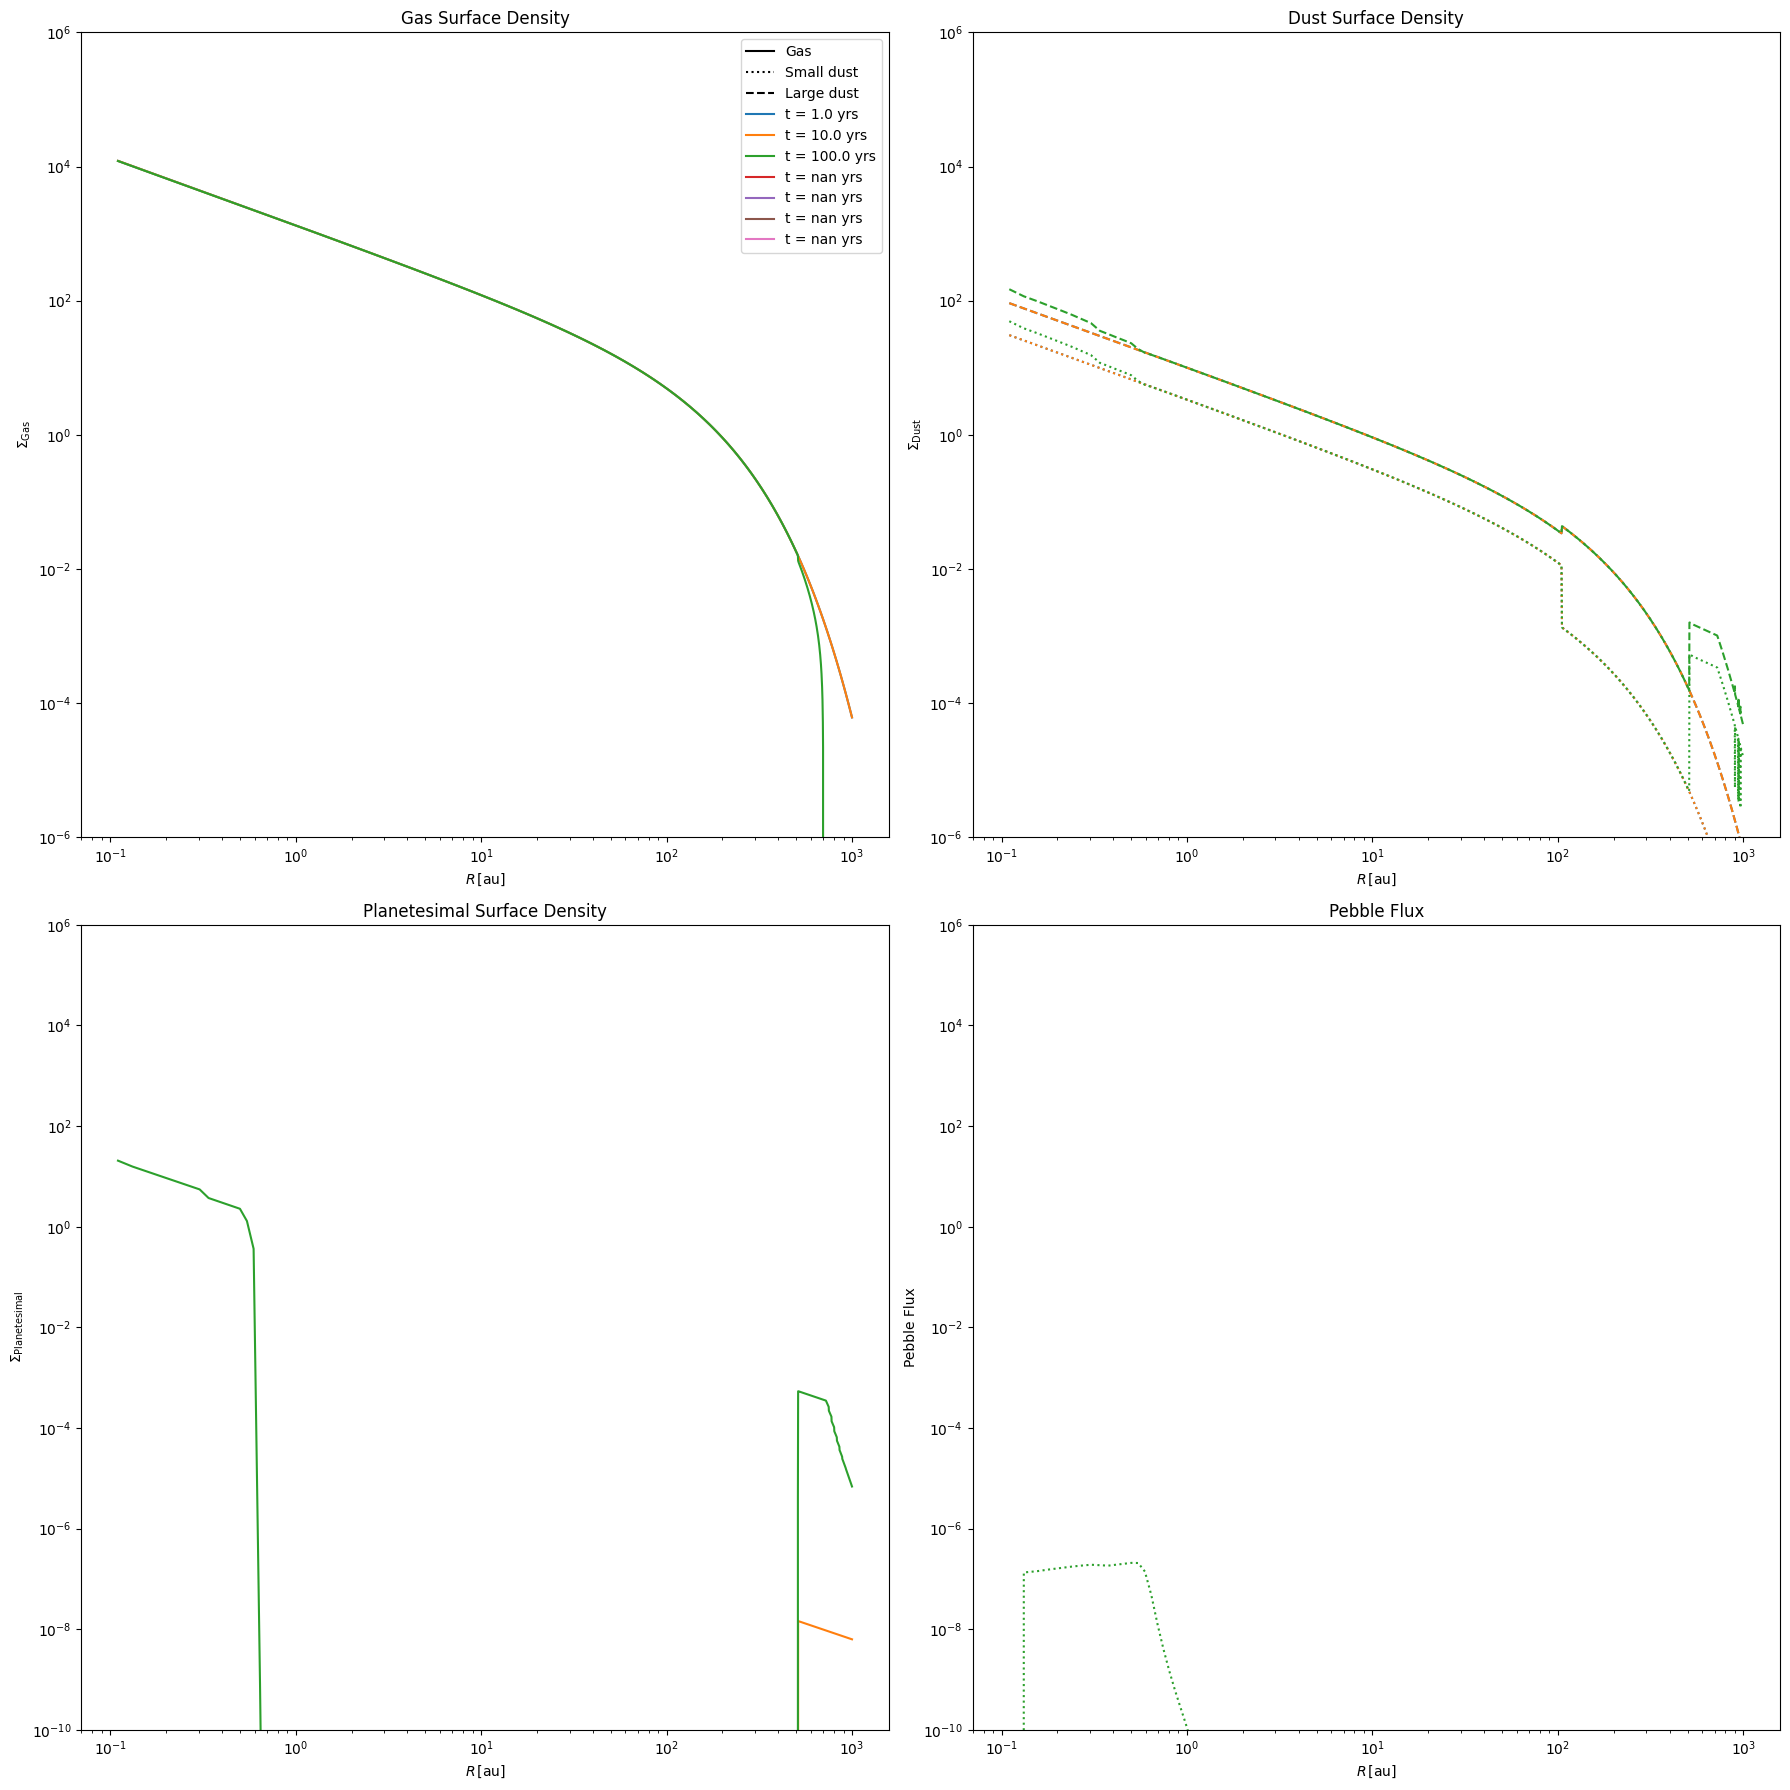

Nstep: 1
Time: 1.0 yr
Nstep: 2
Time: 10.0 yr
Nstep: 6
Time: 100.0 yr
Nstep: 43
Time: 999.9999999999999 yr


C:\Users\rocks\AppData\Local\Temp\ipykernel_27884\602427654.py:106: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].loglog(grid.Rc, dust.v_drift[0], linestyle="dotted", color=l.get_color())


Nstep: 378
Time: 10000.0 yr
Nstep: 1969
Time: 100000.0 yr
Nstep: 16402
Time: 1000000.0 yr


C:\Users\rocks\AppData\Local\Temp\ipykernel_27884\602427654.py:139: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


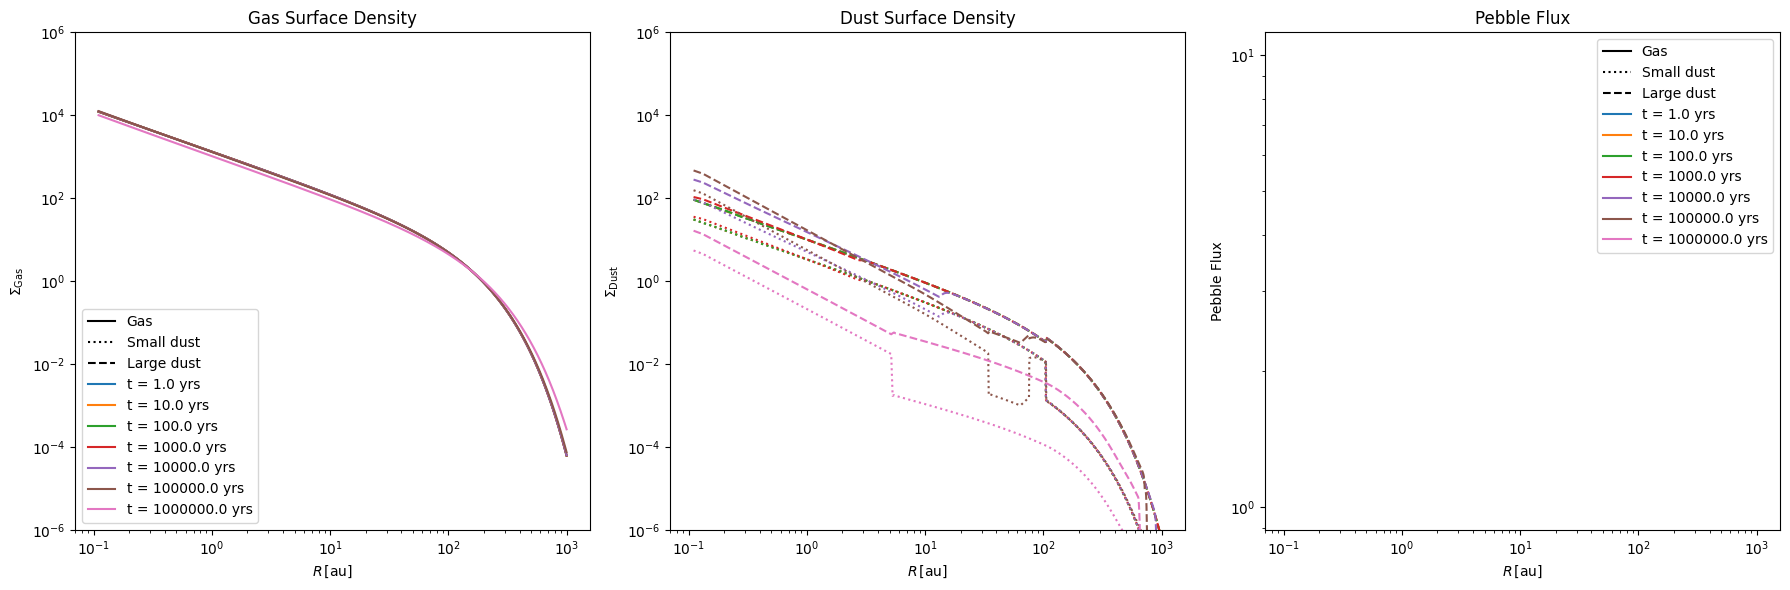

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def run_model(include_planetesimals=True):
    """
    Run the disk evolution model and plot the results.
    
    Parameters:
    include_planetesimals (bool): Whether to include planetesimal formation in the model.
    """
    # Set up model
    # ========================
    # Create the grid
    grid = Grid(rmin, rmax, nr, spacing)
    
    # Create time array
    if t_interval == "power":
        # Determine the number of points needed
        if t_initial == 0:
            num_points = int(np.log10(t_final)) + 1
            times = np.logspace(0, np.log10(t_final), num=num_points) * 2 * np.pi
        else:
            num_points = int(np.log10(t_final / t_initial)) + 1
            times = np.logspace(np.log10(t_initial), np.log10(t_final), num=num_points) * 2 * np.pi
    else:
        times = np.arange(t_initial, t_final, t_interval) * 2 * np.pi
    
    # Create the star
    star = SimpleStar()
    
    # Create the EOS
    eos = LocallyIsothermalEOS(star, h0, q, alpha)
    eos.set_grid(grid)
    
    # Set up initial surface density
    Sigma = (mdot / (3 * np.pi * eos.nu)) * np.exp(-grid.Rc/100.)
    
    # Set up dynamics
    gas = ViscousEvolution()
    dust = DustGrowthTwoPop(grid, star, eos, d2g, Sigma=Sigma)
    drift = SingleFluidDrift(settling=settling, planetesimal=include_planetesimals)
    
    if include_planetesimals:
        planetesimal = PlanetesimalFormation(dust)
    
    # Run model
    # ========================
    t = 0
    n = 0
    
    # Prepare plots
    if include_planetesimals:
        fig, axes = plt.subplots(2, 2, figsize=(18, 18))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Set up initial plot lines
    for ax in axes:
        ax.plot(grid.Rc, 0*grid.Rc, '-', color='black', label="Gas")
        ax.plot(grid.Rc, 0*grid.Rc, linestyle="dotted", color='black', label="Small dust")
        ax.plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Large dust")
    
    for ti in times:
        while t < ti:
            dt = drift.max_timestep(dust)
            dti = min(dt, ti - t)
            
            v_visc = gas.viscous_velocity(dust)
            
            drift(dti, dust, v_visc=v_visc)
            gas(dti, dust, [dust.dust_frac])
            
            # Pin the values to >= 0 and <=1:
            dust.Sigma[:] = np.maximum(dust.Sigma, 0)        
            try:
                dust.dust_frac[:] = np.maximum(dust.dust_frac, 0)
                dust.dust_frac[:] /= np.maximum(dust.dust_frac.sum(0), 1.0)
            except AttributeError:
                pass
            
            if include_planetesimals:
                planetesimal.update(dt, dust, drift)
            
            dust.update(dti)
            
            t = np.minimum(t + dt, ti)
            n += 1

        print('Nstep: {}'.format(n))
        print('Time: {} yr'.format(t / (2 * np.pi)))
            
        l, = axes[0].loglog(grid.Rc, dust.Sigma_G, label='t = {} yrs'.format(np.round(t / (2 * np.pi))))
        axes[1].loglog(grid.Rc, dust.Sigma_D[0], linestyle="dotted", color=l.get_color())
        axes[1].loglog(grid.Rc, dust.Sigma_D[1], linestyle='dashed', color=l.get_color())
        
        if include_planetesimals:
            axes[2].loglog(grid.Rc, dust.Sigma_D[2], '-', color=l.get_color())
            
            axes[3].plot(grid.Rc, 0*grid.Rc, label='t = {} yrs'.format(np.round(t / (2 * np.pi))), color=l.get_color())
            axes[3].loglog(grid.Rc, dust.v_drift[0], linestyle="dotted", color=l.get_color())
            axes[3].loglog(grid.Rc, dust.v_drift[1], linestyle='dashed', color=l.get_color())
            
        else:
            axes[2].plot(grid.Rc, 0*grid.Rc, label='t = {} yrs'.format(np.round(t / (2 * np.pi))), color=l.get_color())
            axes[2].loglog(grid.Rc, dust.v_drift[0], linestyle="dotted", color=l.get_color())
            axes[2].loglog(grid.Rc, dust.v_drift[1], linestyle='dashed', color=l.get_color())

    # Finalize plots
    axes[0].set_xlabel('$R\\,[\\mathrm{au}]$')
    axes[0].set_ylabel('$\\Sigma_{\\mathrm{Gas}}$')
    axes[0].set_ylim(ymin=1e-6, ymax=1e6)
    axes[0].set_title('Gas Surface Density')
    axes[0].legend()

    axes[1].set_xlabel('$R\\,[\\mathrm{au}]$')
    axes[1].set_ylabel('$\\Sigma_{\\mathrm{Dust}}$')
    axes[1].set_ylim(ymin=1e-6, ymax=1e6)
    axes[1].set_title('Dust Surface Density')
    
    if include_planetesimals:
        axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
        axes[2].set_ylabel('$\\Sigma_{\\mathrm{Planetesimal}}$')
        axes[2].set_ylim(ymin=1e-10, ymax=1e6)
        axes[2].set_title('Planetesimal Surface Density')
        
        axes[3].set_xlabel('$R\\,[\\mathrm{au}]$')
        axes[3].set_ylabel('Pebble Flux')
        axes[3].set_ylim(ymin=1e-10, ymax=1e6)
        axes[3].set_title('Pebble Flux')
    else:

        axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
        axes[2].set_ylabel('Pebble Flux')
        #axes[2].set_ylim(ymin=1e-10, ymax=1e6)
        axes[2].set_title('Pebble Flux')
        axes[2].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# With planetesimals (2x2 plot)
run_model(include_planetesimals=True)

# Without planetesimals (1x3 plot)
run_model(include_planetesimals=False)